In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
#torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

1
True


In [3]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
momentum = 0.9
num_epoch_atp = 50
num_epoch = 15

In [4]:
# Data
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

data_path = '/home/put_data/frank840925/IDP/data'
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=4)

valset = torchvision.datasets.MNIST(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0), 
                                        num_workers=4)

testset = torchvision.datasets.MNIST(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,5000),
                                        num_workers=4)

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

60000
10000
10000


In [5]:
# Helper functions
def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="val")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    #plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="val")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Val accuracy") 
    #plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([32, 1, 28, 28])


In [6]:
class LeNet_MNIST(nn.Module):
    def __init__(self):
        super(LeNet_MNIST, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(1, 16, 5, padding=2),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(16, 32, 5),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.Linear(32*5*5, 120),
                                        nn.ReLU(True),
                                        nn.Linear(120, 84),
                                        nn.ReLU(True),
                                        nn.Linear(84, 10))

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [7]:
lenet = LeNet_MNIST().type(dtype)
print(list(lenet.features.children()))

[Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))]


In [8]:
x = Variable(torch.randn(32,1,28,28)).type(dtype)
lenet(x).size()

torch.Size([32, 10])

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)  
        
class first_idp_tensor_3(nn.Module):
    def __init__(self, idp1=0.35, idp2=0.7, idp3=1):
        super(first_idp_tensor_3, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
    def forward(self, c):
        #input the first conv-Relu-Linear output, N*C*H*W, replicate and apply idp and concat in first dim (N)
        N, C, H, W = c.size()
        non_zero_channel_1 = int(C*(self.idp1))
        non_zero_channel_2 = int(C*(self.idp2))
        non_zero_channel_3 = int(C*(self.idp3))
        if C-non_zero_channel_1 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c1 = torch.cat([c[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
        else:
            c1 = c
        if C-non_zero_channel_2 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c2 = torch.cat([c[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
        else:
            c2 = c
        if C-non_zero_channel_3 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_3, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c3 = torch.cat([c[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
        else:
            c3 = c
        out = torch.cat([c1, c2, c3], 0)
        return out
        
class middle_idp_tensor_3(nn.Module):
    def __init__(self, idp1=0.35, idp2=0.7, idp3=1):
        super(middle_idp_tensor_3, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
    def forward(self, c):
        #input a middle conv-Relu-Linear output, (3*N)*C*H*W, apply IDP1, IDP2, IDP3 to each
        NN, C, H, W = c.size()
        if NN>=3:
            N = int(NN/3)
            non_zero_channel_1 = int(C*(self.idp1))
            non_zero_channel_2 = int(C*(self.idp2))
            non_zero_channel_3 = int(C*(self.idp3))
            c1 = c[:N,:,:,:]
            c2 = c[N:2*N,:,:,:]
            c3 = c[2*N:,:,:,:]
            if C-non_zero_channel_1 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c1 = torch.cat([c1[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
            else:
                c1 = c1
            if C-non_zero_channel_2 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c2 = torch.cat([c2[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
            else:
                c2 = c2
            if C-non_zero_channel_3 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_3, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c3 = torch.cat([c3[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
            else:
                c3 = c3
            out = torch.cat([c1, c2, c3],0)
            return out
        else:
            return c
    
class func_trainable1(nn.Module):
    def __init__(self):
        super(func_trainable1, self).__init__()
        self.coeff_tensor =  nn.Parameter(torch.ones(16).type(dtype)) 
    
    def forward(self, x):
        N, C, H, W = x.size()
        coeff_tensor = self.coeff_tensor.view(C, 1)
        coeff_tensor = coeff_tensor.expand(C, H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        
        x = torch.mul(x.clone(), coeff_tensor)
        return x
    
class func_trainable2(nn.Module):
    def __init__(self):
        super(func_trainable2, self).__init__()
        self.coeff_tensor =  nn.Parameter(torch.ones(32).type(dtype))  
    
    def forward(self, x):
        N, C, H, W = x.size()
        coeff_tensor = self.coeff_tensor.view(C, 1)
        coeff_tensor = coeff_tensor.expand(C, H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        
        x = torch.mul(x.clone(), coeff_tensor)
        return x

In [10]:
class atp_tesla_coef_idp_lenet_3branch(nn.Module):
    def __init__(self, idp_layers, model, idp1=0.35, idp2=0.7, idp3=1):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 1,4
        super(atp_tesla_coef_idp_lenet_3branch, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list(model)))
        self.classifier = model.classifier
        
    def new_features_list(self, model):
        new_layers = nn.ModuleList()
        for i, layer in enumerate(list(model.features.children())):
            if i ==1:
                new_layers.append(layer)
                new_layers.append(func_trainable1())
                new_layers.append(first_idp_tensor_3(self.idp1, self.idp2, self.idp3))
            elif i not in self.idp_layers:
                new_layers.append(layer)                
            else:
                new_layers.append(layer)
                new_layers.append(func_trainable2())
                new_layers.append(middle_idp_tensor_3(self.idp1, self.idp2, self.idp3))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        f = self.features(x)
        NN, M = f.size()
        N = int(NN/3)
        o1 = f[:N, :]
        o2 = f[N:2*N, :]
        o3 = f[2*N:,:]
        o1 = self.classifier(o1)
        o2 = self.classifier(o2)
        o3 = self.classifier(o3)
        return o1, o2, o3

In [11]:
def atp_train_tesla_3(num_epoch, net, criterion, optimizer1, optimizer2, alpha1=0, alpha2=0, alpha3=1, index=2):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    gamma1_history = [] #size 6
    gamma2_history = [] #size 16

    # start training
    for epoch in range(num_epoch):
        if epoch%2 == 0:
            #train weight and bias
            running_loss1 = []
            running_loss2 = []
            running_correct1=[]
            running_correct2=[]
            for i, data in enumerate(trainloader, 0):
                correct = 0
                net.train(True)
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
                # zero the parameter gradients
                optimizer1.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs)
                loss1 = criterion(outputs[0], labels) #idp-low
                loss2 = criterion(outputs[1], labels) #idp-mid
                loss3 = criterion(outputs[2], labels) #idp-high
                loss = alpha1*loss1+alpha2*loss2+alpha3*loss3
                loss.backward()
                optimizer1.step()
                # print statistics
                # loss
                running_loss1.append(loss.data[0])
                # accuracy
                _, predicted = torch.max(outputs[index].data, 1)
                correct += (predicted == labels.data).sum()
                correct = correct/labels.size(0)*100
                running_correct1.append(correct)

            for i, tdata in enumerate(valloader, 0):
                test_correct = 0
                net.train(False)
                tinputs, tlabels = tdata
                tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
                toutputs = net(tinputs)
                tloss1 = criterion(toutputs[0], tlabels)
                tloss2 = criterion(toutputs[1], tlabels)
                tloss3 = criterion(toutputs[2], tlabels)
                tloss = alpha1*tloss1+alpha2*tloss2+alpha3*loss3
                running_loss2.append(tloss.data[0])
                _, tpredicted = torch.max(toutputs[index].data, 1)
                test_correct += (tpredicted == tlabels.data).sum()
                test_correct = test_correct/tlabels.size(0)*100
                running_correct2.append(test_correct)
        
        
            train_loss.append(np.mean(running_loss1))
            test_loss.append(np.mean(running_loss2))
            train_acc.append(np.mean(running_correct1))
            test_acc.append(np.mean(running_correct2))
        
            #statistics
            print('Epoch [%d/%d], Train Loss:%.3f, Val Loss:%.3f, Train Accuracy:%.3f percent, Val Accuracy:%.3f percent' 
                        %(epoch, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
        
        elif epoch%2 ==1:
            #train gamma, and manually clip it 
            running_loss1 = []
            running_loss2 = []
            running_correct1=[]
            running_correct2=[]
            for i, data in enumerate(trainloader, 0):
                correct = 0
                net.train(True)
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
                # zero the parameter gradients
                optimizer2.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs)
                loss1 = criterion(outputs[0], labels) #idp-low
                loss2 = criterion(outputs[1], labels) #idp-mid
                loss3 = criterion(outputs[2], labels) #idp-high
                loss = alpha1*loss1+alpha2*loss2+alpha3*loss3
                loss.backward()
                optimizer2.step()
                # print statistics
                # loss
                running_loss1.append(loss.data[0])
                # accuracy
                _, predicted = torch.max(outputs[index].data, 1)
                correct += (predicted == labels.data).sum()
                correct = correct/labels.size(0)*100
                running_correct1.append(correct)

            for i, tdata in enumerate(valloader, 0):
                test_correct = 0
                net.train(False)
                tinputs, tlabels = tdata
                tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
                toutputs = net(tinputs)
                tloss1 = criterion(toutputs[0], tlabels)
                tloss2 = criterion(toutputs[1], tlabels)
                tloss3 = criterion(toutputs[2], tlabels)
                tloss = alpha1*tloss1+alpha2*tloss2+alpha3*loss3
                running_loss2.append(tloss.data[0])
                _, tpredicted = torch.max(toutputs[index].data, 1)
                test_correct += (tpredicted == tlabels.data).sum()
                test_correct = test_correct/tlabels.size(0)*100
                running_correct2.append(test_correct)
                
            #clip weight manually
            for i, (name, param) in enumerate(net.named_parameters()):
                if name.endswith('2.coeff_tensor'):
                    new_param = param.clone()
                    for i in range(1, len(param)):
                        new_param[i] = torch.clamp(new_param[i], max=new_param[i-1].data[0])
                    param = new_param
                    gamma1_history.append(param.data.cpu().numpy())
                elif name.endswith('7.coeff_tensor'):
                    new_param = param.clone()
                    for i in range(1, len(param)):
                        new_param[i] = torch.clamp(new_param[i], max=new_param[i-1].data[0])
                    param = new_param
                    gamma2_history.append(param.data.cpu().numpy())
        
            train_loss.append(np.mean(running_loss1))
            test_loss.append(np.mean(running_loss2))
            train_acc.append(np.mean(running_correct1))
            test_acc.append(np.mean(running_correct2))

            #statistics
            print('Epoch [%d/%d], Train Loss:%.3f, Val Loss:%.3f, Train Accuracy:%.3f percent, Val Accuracy:%.3f percent' 
                        %(epoch, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
        
        #save model every 10 epoch
        if epoch!=0 and epoch%10 ==0:
            file = 'saved_models/'+str(epoch)+'_epoch_atp_tesla_linear_idp_model.pkl'
            torch.save(net.state_dict(), file)
        #early stopping
        if epoch >= 3:
            if (test_acc[-1]-test_acc[-2])<=0 and (test_acc[-1]-test_acc[-3])<=0 and (test_acc[-1]-test_acc[-4])<=0  and (test_acc[-1]-test_acc[-5])<=0:
                print('Early stopping')
                return train_loss, test_loss, train_acc, test_acc, gamma1_history, gamma2_history
            else:
                continue
        
    print('Finished Training')
    return train_loss, test_loss, train_acc, test_acc, gamma1_history, gamma2_history

In [12]:
def train_tesla_3(num_epoch, net, criterion, optimizer, alpha1=0, alpha2=0, alpha3=1, index=2):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    # start training
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss1 = []
        running_loss2 = []
        running_correct1=[]
        running_correct2=[]
        for i, data in enumerate(trainloader, 0):
            correct = 0
            net.train(True)
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss1 = criterion(outputs[0], labels) #idp-low
            loss2 = criterion(outputs[1], labels) #idp-mid
            loss3 = criterion(outputs[2], labels) #idp-high
            
            loss = alpha1*loss1+alpha2*loss2+alpha3*loss3
            
            loss.backward()
            optimizer.step()
            # print statistics
            # loss
            running_loss1.append(loss.data[0])
            # accuracy
            _, predicted = torch.max(outputs[index].data, 1)
            correct += (predicted == labels.data).sum()
            correct = correct/labels.size(0)*100
            running_correct1.append(correct)

        for i, tdata in enumerate(valloader, 0):
            test_correct = 0
            net.train(False)
            tinputs, tlabels = tdata
            tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
            toutputs = net(tinputs)
            tloss1 = criterion(toutputs[0], tlabels)
            tloss2 = criterion(toutputs[1], tlabels)
            tloss3 = criterion(toutputs[2], tlabels)
            
            tloss = alpha1*tloss1+alpha2*tloss2+alpha3*loss3
            
            running_loss2.append(tloss.data[0])
            _, tpredicted = torch.max(toutputs[index].data, 1)
            test_correct += (tpredicted == tlabels.data).sum()
            test_correct = test_correct/tlabels.size(0)*100
            running_correct2.append(test_correct)

        train_loss.append(np.mean(running_loss1))
        test_loss.append(np.mean(running_loss2))
        train_acc.append(np.mean(running_correct1))
        test_acc.append(np.mean(running_correct2))

        #statistics
        print('Epoch [%d/%d], Train Loss:%.3f, Val Loss:%.3f, Train Accuracy:%.3f percent, Val Accuracy:%.3f percent' 
                    %(epoch, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
        #save model every 10 epoch
        if epoch!=0 and epoch%10 ==0:
            file = 'saved_models/'+str(epoch)+'_epoch_atp_tesla_linear_idp_model.pkl'
            torch.save(net.state_dict(), file)
        #early stopping
        if epoch >= 4:
            if (test_acc[-1] - test_acc[-2]) <=0 and (test_acc[-1] - test_acc[-3]) <= 0 and (test_acc[-1] - test_acc[-4]) <= 0:
                print('Early stopping')
                return train_loss, test_loss, train_acc, test_acc
            else:
                continue
        
    print('Finished Training')
    return train_loss, test_loss, train_acc, test_acc

In [13]:
# define models, optimizers, training
idp_ranges = [0.1, 0.3, 1]
all_train_loss = []
all_test_loss = []
all_train_acc = []
all_test_acc = []
gamma1_history = []
gamma2_history = []

criterion = nn.CrossEntropyLoss()

idp_layers = {1,4}
net = atp_tesla_coef_idp_lenet_3branch(idp_layers, lenet, idp1=idp_ranges[0], idp2=idp_ranges[1], idp3=idp_ranges[2]).type(dtype)

In [14]:
x = Variable(torch.randn(32, 1, 28, 28)).type(dtype)
out = net(x)
print(out[0].size())
print(out[1].size())
print(out[2].size())

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])


In [15]:
for i, (name, param) in enumerate(net.named_parameters()):
    print(name, param.size())

features.0.weight torch.Size([16, 1, 5, 5])
features.0.bias torch.Size([16])
features.2.coeff_tensor torch.Size([16])
features.5.weight torch.Size([32, 16, 5, 5])
features.5.bias torch.Size([32])
features.7.coeff_tensor torch.Size([32])
classifier.0.weight torch.Size([120, 800])
classifier.0.bias torch.Size([120])
classifier.2.weight torch.Size([84, 120])
classifier.2.bias torch.Size([84])
classifier.4.weight torch.Size([10, 84])
classifier.4.bias torch.Size([10])


In [16]:
params_w_b = []
params_gamma = []

for i, (name, param) in enumerate(net.named_parameters()):
    if name.endswith('coeff_tensor'):
        params_gamma.append(param)
    else:
        params_w_b.append(param)

print(len(list(net.parameters())))
print(len(params_w_b))
print(len(params_gamma))

optimizer1 = optim.SGD(params_w_b, lr=learning_rate, momentum=momentum)
optimizer2 = optim.SGD(params_gamma, lr=learning_rate/2, momentum=momentum)


for index in range(0, len(idp_ranges)+1):
    if index == 0:
        print('train with idp3')
        train_loss, test_loss, train_acc, test_acc, g1_history, g2_history = atp_train_tesla_3(num_epoch_atp, net, criterion, optimizer1,
                                                                 optimizer2, alpha1=0, alpha2=0, alpha3=1, index=2)
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)
        gamma1_history.extend(g1_history)
        gamma2_history.extend(g2_history)
    elif index ==1:
        print('train with idp3 again')
        train_loss, test_loss, train_acc, test_acc = train_tesla_3(num_epoch, net, criterion, optimizer1,
                                                                 alpha1=0, alpha2=0, alpha3=1, index=2)        
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)
    elif index ==2:
        print('train with idp2')
        train_loss, test_loss, train_acc, test_acc = train_tesla_3(num_epoch, net, criterion, optimizer1,
                                                                 alpha1=0, alpha2=0.5, alpha3=0.5, index=1)        
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)
    else:
        print('train with idp1')
        train_loss, test_loss, train_acc, test_acc = train_tesla_3(num_epoch, net, criterion, optimizer1,
                                                                  alpha1=0.5, alpha2=0.25, alpha3=0.25, index=0)        
        all_train_loss.extend(train_loss)
        all_test_loss.extend(test_loss)
        all_train_acc.extend(train_acc)
        all_test_acc.extend(test_acc)

12
10
2
train with idp3
Epoch [0/50], Train Loss:0.533, Val Loss:0.089, Train Accuracy:83.845 percent, Val Accuracy:95.064 percent
Epoch [1/50], Train Loss:0.126, Val Loss:0.052, Train Accuracy:96.232 percent, Val Accuracy:95.362 percent
Epoch [2/50], Train Loss:0.099, Val Loss:0.074, Train Accuracy:97.007 percent, Val Accuracy:96.895 percent
Epoch [3/50], Train Loss:0.075, Val Loss:0.021, Train Accuracy:97.727 percent, Val Accuracy:97.313 percent
Epoch [4/50], Train Loss:0.069, Val Loss:0.082, Train Accuracy:97.907 percent, Val Accuracy:97.930 percent
Epoch [5/50], Train Loss:0.052, Val Loss:0.143, Train Accuracy:98.423 percent, Val Accuracy:97.870 percent
Epoch [6/50], Train Loss:0.054, Val Loss:0.039, Train Accuracy:98.340 percent, Val Accuracy:97.950 percent
Epoch [7/50], Train Loss:0.045, Val Loss:0.021, Train Accuracy:98.625 percent, Val Accuracy:98.109 percent
Epoch [8/50], Train Loss:0.045, Val Loss:0.032, Train Accuracy:98.552 percent, Val Accuracy:98.209 percent
Epoch [9/50],

In [17]:
# Save the Model
torch.save(net.state_dict(), 'saved_models/mnist_atp_100_30_10_tesla_3branch_idp_model.pkl')

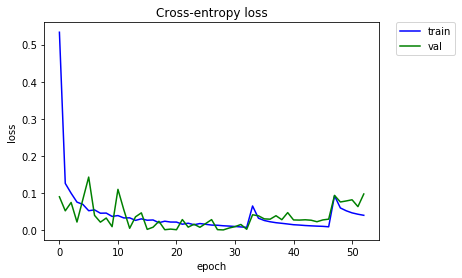

In [18]:
plot_losses(all_train_loss, all_test_loss)

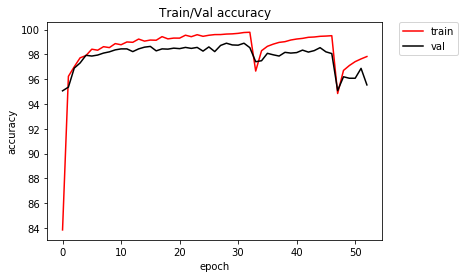

In [19]:
plot_accuracy(all_train_acc, all_test_acc)

In [20]:
# Load the trained model
net.load_state_dict(torch.load('saved_models/mnist_atp_100_30_10_tesla_3branch_idp_model.pkl'))

In [21]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs1, outputs2, outputs3 = model.forward(Variable(images, volatile=True).type(dtype))
        labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs3.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network with IDP 100 on the test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net.eval())

Accuracy of the network with IDP 100 on the test images: 99 %


99.4

In [22]:
idp_acc_history = []
idp_harmonic_history = [0]*20

idp_scale = list(map(lambda x: x/20,range(2,21)))
print(idp_scale)
for i in idp_scale:
    net_inference = atp_tesla_coef_idp_lenet_3branch(idp_layers, lenet, idp1=1, idp2=1, idp3=i).type(dtype)
    net_inference.load_state_dict(torch.load('saved_models/mnist_atp_100_30_10_tesla_3branch_idp_model.pkl'))
    a = test_acccuracy(testloader, net_inference.eval())
    idp_acc_history.append(a)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Accuracy of the network with IDP 100 on the test images: 97 %
Accuracy of the network with IDP 100 on the test images: 95 %
Accuracy of the network with IDP 100 on the test images: 92 %
Accuracy of the network with IDP 100 on the test images: 99 %
Accuracy of the network with IDP 100 on the test images: 99 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network with IDP 100 on the test images: 98 %
Accuracy of the network wit

In [23]:
idp_acc_history

[97.44,
 95.54,
 92.7,
 99.1,
 99.0,
 98.68,
 98.82,
 98.72,
 98.18,
 98.06,
 98.4,
 98.4,
 98.78,
 98.9,
 98.76,
 98.98,
 99.0,
 97.98,
 99.4]

In [27]:
atp_100_50_10 = [98.72,
 90.98,
 64.84,
 66.54,
 68.58,
 70.76,
 56.7,
 66.74,
 99.38,
 99.28,
 99.14,
 99.02,
 98.62,
 99.1,
 99.1,
 99.24,
 99.18,
 99.48,
 99.58]

In [29]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig3 = plt.figure()
    ax1 = fig3.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(2,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='o', linestyle='-', color='r', label="atp-100-30-10")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, marker='o', linestyle='-', color='g', label="atp-100-50-10")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("ATP-IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("ATP-Lenet5 (MNIST)")

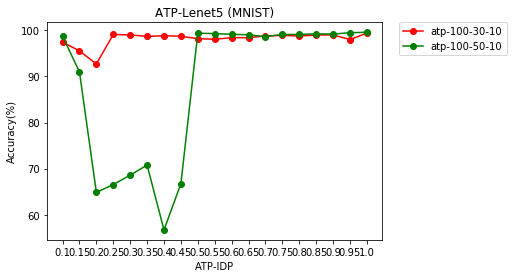

In [30]:
plot_idp_accuracy(idp_acc_history, atp_100_50_10)

In [31]:
g1_history[-1]

array([ 1.34105968,  0.9327364 ,  0.9327364 ,  0.9327364 ,  0.9327364 ,
        0.9327364 ,  0.9327364 ,  0.9327364 ,  0.9327364 ,  0.9327364 ,
        0.9327364 ,  0.9327364 ,  0.90740663,  0.90740663,  0.90740663,
        0.65693974], dtype=float32)

In [32]:
g2_history[-1]

array([ 0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838,  0.74590838,  0.74590838,  0.74590838,
        0.74590838,  0.74590838], dtype=float32)

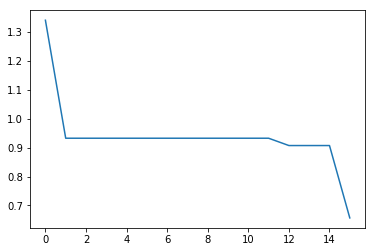

In [33]:
plt.plot(g1_history[-1])
plt.show()

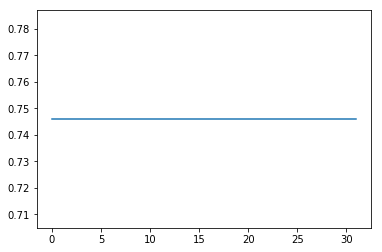

In [41]:
plt.plot(g2_history[-1])
plt.show()